# Analysis of Citibike bike dock stations

In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as cx

# import our helpers module. appending parent directory ("..") to sys.path might be necessary for helpers to be imported on some systems
import sys

sys.path.insert(0, "..")
import helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data
* trips
* stations
* boros shapefile

In [ ]:
DATA_DIR = "../data/"
STATIONS_DIR = DATA_DIR + "stations/"
CRS_WEB_MERCATOR = 3857
CRS_OPENSTREETMAP = "WGS-84"
TRIP_YEAR = 2019

In [ ]:
%%time
trips = helpers.get_trips(TRIP_YEAR, DATA_DIR, convert_dates=True)
trips

CPU times: user 39.2 s, sys: 26.4 s, total: 1min 5s
Wall time: 1min 9s


,tripduration,starttime,stoptime,startstationid,endstationid,bikeid,usertype,birthyear,gender
0,320,2019-01-01 00:01:47.401,2019-01-01 00:07:07.581,3160,3283,15839,Subscriber,1971,1
1,316,2019-01-01 00:04:43.736,2019-01-01 00:10:00.608,519,518,32723,Subscriber,1964,1
2,591,2019-01-01 00:06:03.997,2019-01-01 00:15:55.438,3171,3154,27451,Subscriber,1987,1
3,2719,2019-01-01 00:07:03.545,2019-01-01 00:52:22.650,504,3709,21579,Subscriber,1990,1
4,303,2019-01-01 00:07:35.945,2019-01-01 00:12:39.502,229,503,35379,Subscriber,1979,1
...,...,...,...,...,...,...,...,...,...
20551512,729,2019-10-31 23:59:12.190,2019-11-01 00:11:21.486,237,311,25725,Subscriber,1995,1
20551513,645,2019-10-31 23:59:17.047,2019-11-01 00:10:02.945,3259,461,39583,Customer,1969,0
20551514,257,2019-10-31 23:59:22.514,2019-11-01 00:03:40.260,3798,505,21240,Subscriber,1985,1
20551515,466,2019-10-31 23:59:23.171,2019-11-01 00:07:09.205,328,361,34916,Subscriber,1989,0


In [ ]:
# get top N stations by start of trips
stations_by_tripcount = (
    trips.groupby("startstationid")["bikeid"]
    .count()
    .reset_index()
    .rename(columns={"bikeid": "counttrips"})
    .sort_values(by="counttrips", ascending=False)
)

In [ ]:
# read stations
stations = pd.read_csv(STATIONS_DIR + "stations.csv", index_col=0)
stations["stationid"] = stations["stationid"].astype("int64")
stations

,stationid,stationname,latitude,longitude,capacity,neighbourhood,boro,zipcode,elevation_ft
0,455,1 Ave & E 44 St,40.750020,-73.969053,59.0,Turtle Bay,Manhattan,10017-6927,46.80
1,434,9 Ave & W 18 St,40.743174,-74.003664,60.0,Chelsea District,Manhattan,10019,15.90
2,491,E 24 St & Park Ave S,40.740964,-73.986022,NaN,Manhattan Community Board 5,Manhattan,10010,34.87
3,384,Fulton St & Waverly Ave,40.683178,-73.965964,31.0,NaN,Brooklyn,11238,78.10
4,474,5 Ave & E 29 St,40.745168,-73.986831,56.0,Midtown South,Manhattan,10035,41.55
...,...,...,...,...,...,...,...,...,...
1425,3685,Prospect Park - 5 Year Anniversary Celebration,40.660652,-73.964590,NaN,NaN,Brooklyn,11225,85.71
1426,3695,E 5 St & 2 Ave,40.726870,-73.989190,NaN,East Village,Manhattan,10003,36.09
1427,3700,E 87 St & 3 Ave,40.779406,-73.953336,NaN,Carnegie Hill,Manhattan,10028,79.35
1428,3805,E 80 St & Park Ave,40.776173,-73.959757,NaN,Manhattan Community Board 8,Manhattan,10075,79.28


In [ ]:
# read boros
# See: https://geopandas.org/en/stable/gallery/plotting_basemap_background.html
# How convenient, they use NYC boroughs!
boros = gpd.read_file(gpd.datasets.get_path("nybb"))
# add coordinates for boro label. See: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
boros = boros.to_crs(epsg=CRS_WEB_MERCATOR)
boros["boro_coords"] = boros["geometry"].apply(
    lambda x: x.representative_point().coords[:]
)
boros["boro_coords"] = [coords[0] for coords in boros["boro_coords"]]
bronx_staten_indices = [0, 4]  # not in our analysis scope
boros

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,boro_coords
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-8243264.851 4948597.836, -824...","(-8253855.166355219, 4949487.184749613)"
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-8219461.925 4952778.732, -821...","(-8217674.952623626, 4968921.613381525)"
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-8222843.672 4950893.793, -822...","(-8231923.121198691, 4961497.6391432695)"
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-8238858.864 4965915.024, -823...","(-8233217.492883665, 4981226.016937203)"
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-8226155.130 4982269.949, -822...","(-8222762.440009881, 4991135.5046057245)"


## Stations EDA

In [ ]:
# get number of stations by year to see growth
# map them
# most popular/least + trips
# elevation does it affect stuff
# more

In [ ]:
# get number of all stations ever
stations.shape

(1430, 9)

In [ ]:
def annotate_boros():
    """
    Annotate boro names See: https://stackoverflow.com/questions/38899190/geopandas-label-polygons
    :return: None
    """
    plt.annotate(
        text=row["BoroName"],
        xy=row["boro_coords"],
        horizontalalignment="left",
        color="Black",
        size=18,
        bbox={
            "boxstyle": "round",
            "facecolor": "white",
            "alpha": 0.8,
            "pad": 0.1,
            "edgecolor": "none",
        },
    )

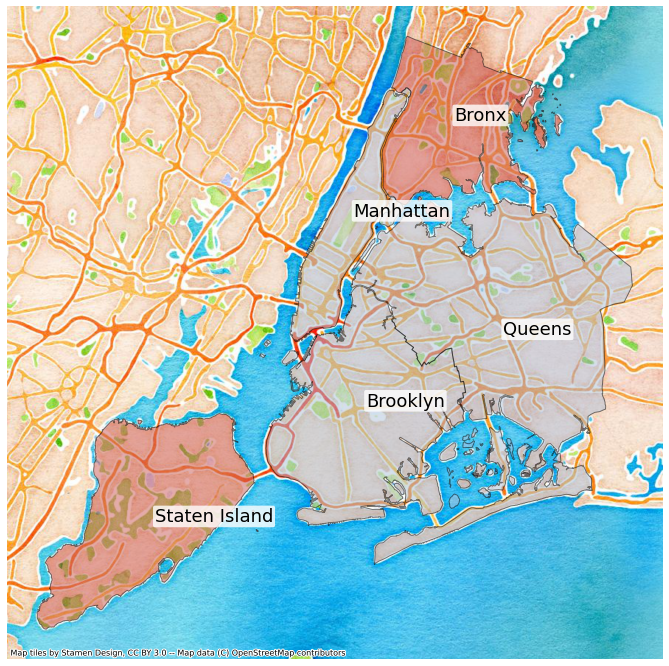

In [ ]:
# plot all 5 boros
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)

for idx, row in boros.iterrows():
    bronx_staten_indices = [0, 4]  # not in our analysis scope
    boro_color = "indianred" if idx in bronx_staten_indices else "lightsteelblue"
    ax = boros[boros.index == idx].plot(
        alpha=0.5, color=boro_color, edgecolor="k", ax=ax
    )
    annotate_boros()
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
ax.axis("off")

plt.show()

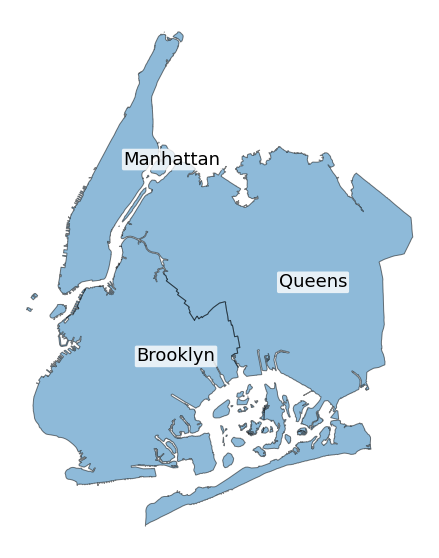

In [ ]:
# drop Staten Island and the Bronx by index
boros.drop(index=[0, 4], inplace=True)
ax = boros.plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
for idx, row in boros.iterrows():
    annotate_boros()
ax.axis("off")
plt.show()

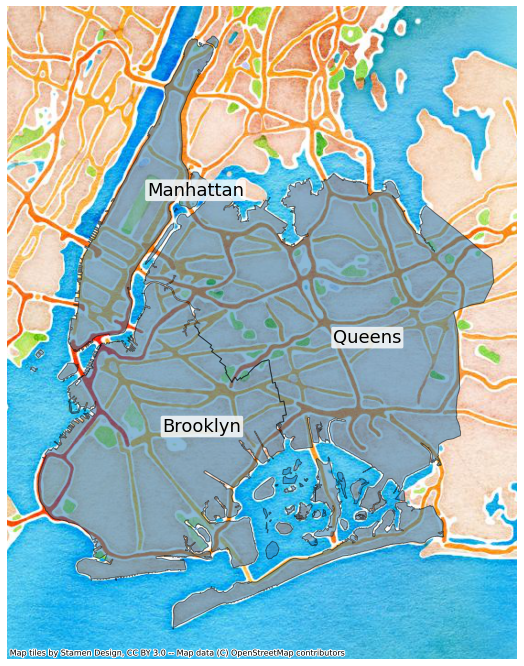

In [ ]:
ax = boros.plot(figsize=(12, 12), alpha=0.5, edgecolor="k")
for idx, row in boros.iterrows():
    annotate_boros()
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
ax.axis("off")
plt.show()

In [ ]:
# drop stations with no latitude or longitude, those in 8D and the Bronx
stations = stations.drop(stations[stations["latitude"] == 0.0].index)
stations = stations.drop(stations[stations["longitude"] == 0.0].index)
stations = stations.drop(stations[stations["boro"] == "Ville-Marie"].index)
stations = stations.drop(stations[stations["boro"] == "The Bronx"].index)

In [ ]:
# merge to get tripcount. NOTE: this drops stations not in TRIP_YEAR
stations = pd.merge(
    left=stations_by_tripcount,
    right=stations,
    how="inner",
    left_on="startstationid",
    right_on="stationid",
).drop("startstationid", axis=1)
stations.insert(0, "stationid", stations.pop("stationid"))

In [ ]:
# create geopandas dataframe and set CRS
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.longitude, stations.latitude)
)
stations_gdf.crs = CRS_OPENSTREETMAP
stations_gdf = stations_gdf.to_crs(epsg=CRS_WEB_MERCATOR)
stations_gdf

,stationid,counttrips,stationname,latitude,longitude,capacity,neighbourhood,boro,zipcode,elevation_ft,geometry
0,519,156575,Pershing Square North,40.751873,-73.977706,NaN,Murray Hill,Manhattan,10037,58.36,POINT (-8235160.562 4975811.591)
1,497,121781,E 17 St & Broadway,40.737050,-73.990093,66.0,Union Square,Manhattan,10010,40.61,POINT (-8236539.472 4973633.600)
2,3255,119958,8 Ave & W 31 St,40.750585,-73.994685,18.0,Chelsea District,Manhattan,10119,34.49,POINT (-8237050.635 4975622.375)
3,402,113138,Broadway & E 22 St,40.740343,-73.989551,NaN,Manhattan Community Board 5,Manhattan,10010,39.94,POINT (-8236479.151 4974117.457)
4,285,113012,Broadway & E 14 St,40.734546,-73.990741,78.0,East Village,Manhattan,10003,40.24,POINT (-8236611.658 4973265.707)
...,...,...,...,...,...,...,...,...,...,...,...
931,3867,8,Somers St & Broadway,40.679450,-73.904740,29.0,NaN,Brooklyn,11233,91.50,POINT (-8227038.024 4965174.968)
932,3250,6,NYCBS Depot - PIT,40.716910,-73.983838,NaN,Lower East Side,Manhattan,10002,24.55,POINT (-8235843.169 4970675.167)
933,3245,6,Kiosk in a box Motivate,40.646678,-74.016303,NaN,Sunset Park,NaN,11220,48.15,POINT (-8239457.207 4960365.592)
934,3909,6,Madison St & Woodward Ave,40.704080,-73.904080,20.0,NaN,Brooklyn,11237,94.82,POINT (-8226964.553 4968791.029)


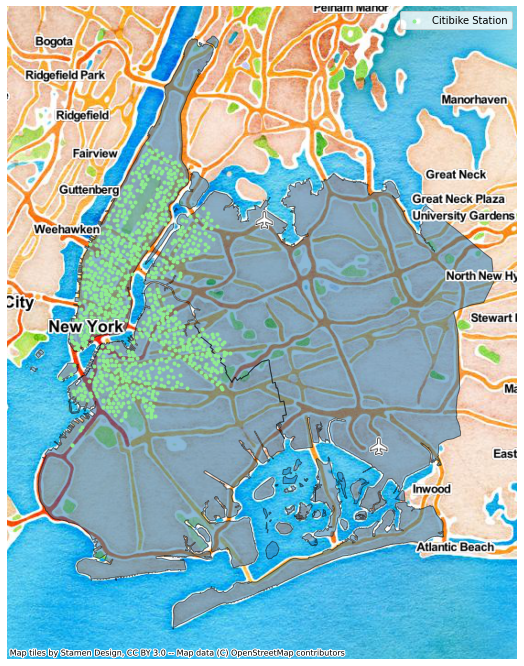

In [ ]:
# plot all stations
# TODO add subway lines https://data.cityofnewyork.us/Transportation/Subway-Lines/3qz8-muuu
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
ax = boros.plot(alpha=0.5, edgecolor="k", ax=ax)
ax = stations_gdf.plot(color="lightgreen", ax=ax, label="Citibike Station", marker=".")
cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.legend()
ax.axis("off")

plt.show()

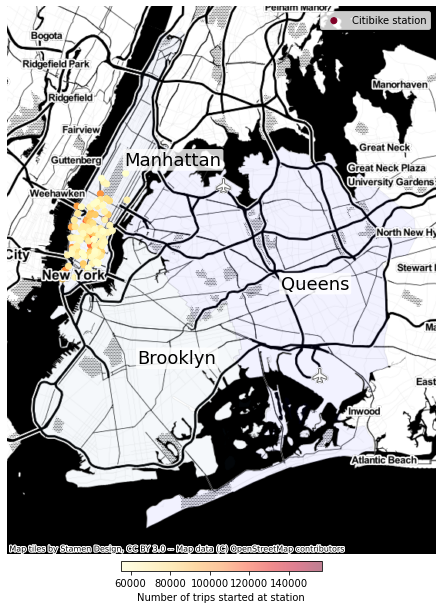

In [ ]:
# plot top stations by tripcount (hint: they're all in Manhattan!)
# TODO plot top N by boro
N = 100
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
boro_colors = ["blue", "steelblue", "royalblue"]
for idx, row in boros.iterrows():
    ax = boros[boros.index == idx].plot(
        alpha=0.05, color=boro_colors[idx - 1], edgecolor="k", ax=ax
    )
    annotate_boros()

stations_gdf_topN = stations_gdf.sort_values(by="counttrips", ascending=False).head(N)
ax = stations_gdf_topN.plot(
    column="counttrips",
    cmap="YlOrRd",
    ax=ax,
    label="Citibike station",
    legend=True,
    legend_kwds={
        "label": "Number of trips started at station",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.3,
        "alpha": 0.5,
    },
)

cx.add_basemap(ax, source=cx.providers.Stamen.Toner)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.legend()
ax.axis("off")

plt.show()

In [ ]:
# trip start stations sorted by tripcount
stations_gdf.sort_values(by="counttrips", ascending=False)

,stationid,counttrips,stationname,latitude,longitude,capacity,neighbourhood,boro,zipcode,elevation_ft,geometry
0,519,156575,Pershing Square North,40.751873,-73.977706,NaN,Murray Hill,Manhattan,10037,58.36,POINT (-8235160.562 4975811.591)
1,497,121781,E 17 St & Broadway,40.737050,-73.990093,66.0,Union Square,Manhattan,10010,40.61,POINT (-8236539.472 4973633.600)
2,3255,119958,8 Ave & W 31 St,40.750585,-73.994685,18.0,Chelsea District,Manhattan,10119,34.49,POINT (-8237050.635 4975622.375)
3,402,113138,Broadway & E 22 St,40.740343,-73.989551,NaN,Manhattan Community Board 5,Manhattan,10010,39.94,POINT (-8236479.151 4974117.457)
4,285,113012,Broadway & E 14 St,40.734546,-73.990741,78.0,East Village,Manhattan,10003,40.24,POINT (-8236611.658 4973265.707)
...,...,...,...,...,...,...,...,...,...,...,...
931,3867,8,Somers St & Broadway,40.679450,-73.904740,29.0,NaN,Brooklyn,11233,91.50,POINT (-8227038.024 4965174.968)
932,3250,6,NYCBS Depot - PIT,40.716910,-73.983838,NaN,Lower East Side,Manhattan,10002,24.55,POINT (-8235843.169 4970675.167)
933,3245,6,Kiosk in a box Motivate,40.646678,-74.016303,NaN,Sunset Park,NaN,11220,48.15,POINT (-8239457.207 4960365.592)
934,3909,6,Madison St & Woodward Ave,40.704080,-73.904080,20.0,NaN,Brooklyn,11237,94.82,POINT (-8226964.553 4968791.029)
